In [1]:
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import PIL
import PIL.Image

# %tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

np.random.seed(42) # note that you must use the same seed to ensure consistentcy in your training/validation/testing
tf.random.set_seed(42)

In [2]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from sklearn.datasets import load_files 
from keras.utils import np_utils

from keras.preprocessing import image
from tqdm import tqdm # progress bar

data_dir = "../data"
batch_size = 32;
# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
img_height = 224; 
img_width = 224;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    image_size = (img_height, img_width),
    batch_size = batch_size
)        


Found 11500 files belonging to 10 classes.
Using 9200 files for training.
Found 11500 files belonging to 10 classes.
Using 2300 files for validation.


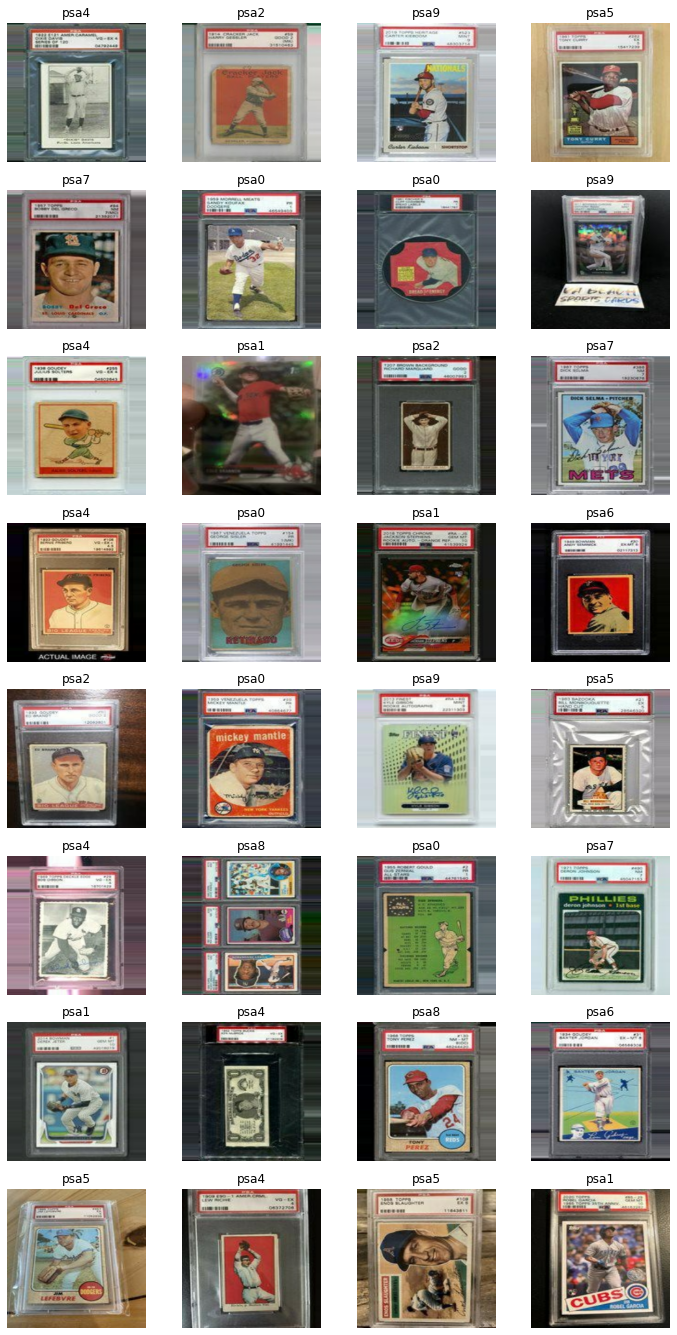

In [4]:
# Visualize some of the train samples of one batch
# Make sure you create the class names that match the order of their appearances in the "files" variable
class_names = ['psa' + str(x) for x in range(0,11)]

# Rows and columns are set to fit one training batch (32)
n_rows = 8
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in train_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[labels[i]], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)


## ResNet50

In [5]:
base_model = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet"
)

In [6]:
model = tf.keras.Sequential([base_model,
                                 tf.keras.layers.GlobalAveragePooling2D(),
                                  tf.keras.layers.Dropout(0.5),
                                 tf.keras.layers.Dense(128, activation='relu'),
                                 tf.keras.layers.Dense(10)                                     
                                ])

In [7]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_ds, epochs = 100, validation_data=validation_ds)

Epoch 1/100
288/288 [==============================] - 35s 100ms/step - loss: 1.8352 - accuracy: 0.2895 - val_loss: 52.2789 - val_accuracy: 0.1030
Epoch 2/100
288/288 [==============================] - 27s 95ms/step - loss: 1.1211 - accuracy: 0.5630 - val_loss: 18.1351 - val_accuracy: 0.1087
Epoch 3/100
288/288 [==============================] - 27s 95ms/step - loss: 0.6503 - accuracy: 0.7698 - val_loss: 0.8669 - val_accuracy: 0.7183
Epoch 4/100
288/288 [==============================] - 27s 95ms/step - loss: 0.4549 - accuracy: 0.8489 - val_loss: 1.2274 - val_accuracy: 0.6457
Epoch 5/100
288/288 [==============================] - 27s 95ms/step - loss: 0.3852 - accuracy: 0.8737 - val_loss: 0.9461 - val_accuracy: 0.7057
Epoch 6/100
288/288 [==============================] - 27s 95ms/step - loss: 0.3392 - accuracy: 0.8891 - val_loss: 0.4214 - val_accuracy: 0.8548
Epoch 7/100
288/288 [==============================] - 27s 95ms/step - loss: 0.3050 - accuracy: 0.9005 - val_loss: 0.9265 - val

288/288 [==============================] - 27s 95ms/step - loss: 0.0387 - accuracy: 0.9887 - val_loss: 0.6156 - val_accuracy: 0.8743
Epoch 58/100
288/288 [==============================] - 27s 95ms/step - loss: 0.0221 - accuracy: 0.9936 - val_loss: 0.5011 - val_accuracy: 0.9122
Epoch 59/100
288/288 [==============================] - 28s 98ms/step - loss: 0.0176 - accuracy: 0.9939 - val_loss: 0.8671 - val_accuracy: 0.8378
Epoch 60/100
288/288 [==============================] - 27s 95ms/step - loss: 0.0352 - accuracy: 0.9912 - val_loss: 0.4468 - val_accuracy: 0.9057
Epoch 61/100
288/288 [==============================] - 27s 95ms/step - loss: 0.0223 - accuracy: 0.9938 - val_loss: 0.4072 - val_accuracy: 0.9165
Epoch 62/100
288/288 [==============================] - 28s 95ms/step - loss: 0.0111 - accuracy: 0.9963 - val_loss: 0.7191 - val_accuracy: 0.8674
Epoch 63/100
288/288 [==============================] - 27s 95ms/step - loss: 0.0134 - accuracy: 0.9971 - val_loss: 0.4824 - val_accuracy

In [8]:
score = model.evaluate(validation_ds)

72/72 [==============================] - 2s 32ms/step - loss: 0.7615 - accuracy: 0.8591


In [ ]:
score2 = model2.evaluate(validation_ds)